<a href="https://colab.research.google.com/github/VanHoann/Facemask_Detector/blob/main/MaskDetector_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Model

In [1]:
!git clone https://github.com/VanHoann/Facemask_Detector

Cloning into 'Facemask_Detector'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 79 (delta 10), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (79/79), done.


In [2]:
import torch

USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device

device(type='cpu')

## Detector (MTCNN)

In [3]:
cd "/content/Facemask_Detector/models/detector"

/content/Facemask_Detector/models/detector


In [4]:
import cv2
from mtcnn.implement.detect import create_mtcnn_net, MtcnnDetector
from mtcnn.implement.vision import vis_face
pnet, rnet, onet = create_mtcnn_net(p_model_path="./final_model/pnet_epoch.pt", r_model_path="./final_model/rnet_epoch.pt", o_model_path="./final_model/onet_epoch.pt", use_cuda=False)
mtcnn_detector = MtcnnDetector(pnet=pnet, rnet=rnet, onet=onet, min_face_size=24)

/content/Facemask_Detector/models/detector/mtcnn/implement/models.py:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight.data)
/content/Facemask_Detector/models/detector/mtcnn/implement/models.py:9: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0.1)


## Classifier (EfficientNet)

In [5]:
cd "/content/Facemask_Detector"

/content/Facemask_Detector


In [7]:
import torch
from models.classifier.model import EfficientNet


effnet = EfficientNet.from_name('efficientnet-b0', num_classes=3)
model_dir = "/content/Facemask_Detector/models/classifier/weights/efficientnet-b0-ckpt5.pth"
effnet.load_state_dict(torch.load(model_dir, map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
effnet.eval()

In [9]:
from models.classifier.dataset import img_size, id2label, transform
print(img_size, id2label)
transform

224 {'0': 'correct', '1': 'incorrect', '2': 'not wearing'}


Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2))
)

# Demo 

In [10]:
from google.colab.patches import cv2_imshow
import numpy as np

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


time cost 0.660  pnet 0.496  rnet 0.147  onet 0.017


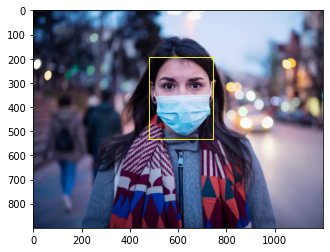

In [11]:
img = cv2.imread("tests/testimage.webp")
img_bg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
bboxs, landmarks = mtcnn_detector.detect_face(img, verbose=True)
save_name = 'test.png'
vis_face(img_bg,bboxs,None, save_name)

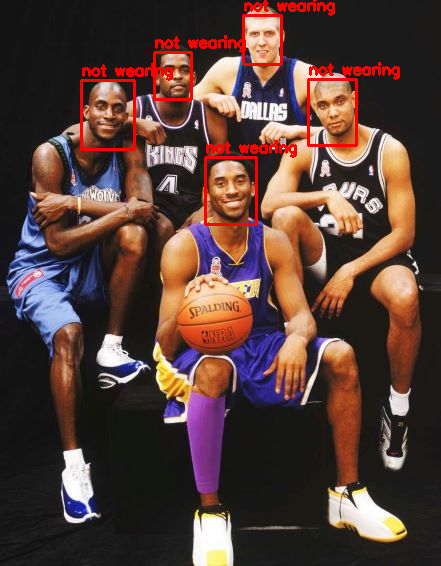

In [12]:
img = cv2.imread("tests/testimage.jpeg")
faces, landmarks = mtcnn_detector.detect_face(img)

# classify image
for i in range(len(faces)):
    (x,y,x2,y2,pro) = faces[i]
    w=x2-x
    h=y2-y
    x=int(x)
    y=int(y)
    w=int(w)
    h=int(h)
    # crop face
    crop = img[y:y+h, x:x+w]
    #cv2_imshow(crop)
    crop = torch.Tensor(np.transpose(crop/255, (2, 0, 1))) 
    #print(crop.shape)

    # classify
    crop = transform(crop)
    crop = torch.unsqueeze(crop, axis=0).to(device)
    scores = effnet(crop)
    _, preds = scores.max(1)
    pred_label = str(preds.tolist()[0])

    class_color = {"0": (0, 255, 0), "1": (0, 255, 255), "2": (0, 0, 255)}

    # draw face bounding box on image
    img = cv2.rectangle(img,(x,y),(x+w,y+h),class_color[pred_label],2)

    # add text
    img = cv2.putText(img, id2label[pred_label],
              (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, class_color[pred_label] ,2)

cv2_imshow(img)

# Using Webcam for demo

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
from google.colab.patches import cv2_imshow

## Helper Functions
Helper function to convert between different image data types and formats. 

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

## Webcam Images
Running code on images taken from webcam 

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))

  # get OpenCV format image
  img = js_to_image(data) 
  print("Shape of the image", img.shape)

  # detect faces
  faces, landmarks = mtcnn_detector.detect_face(img)
  print(faces)
  if len(faces)==0:
      print("There is no face")
      return

  #faces = faces.astype(int)

  # classify image
  for i in range(len(faces)):
      (x,y,x2,y2,pro) = faces[i]
      w=x2-x
      h=y2-y
      x=int(x)
      y=int(y)
      w=int(w)
      h=int(h)
      # crop face
      crop = img[y:y+h, x:x+w]
      #cv2_imshow(crop)
      crop = torch.Tensor(np.transpose(crop/255, (2, 0, 1))) 
      #print(crop.shape)

      # classify
      crop = transform(crop)
      crop = torch.unsqueeze(crop, axis=0).to(device)
      scores = effnet(crop)
      _, preds = scores.max(1)
      pred_label = str(preds.tolist()[0])

      class_color = {"0": (0, 255, 0), "1": (0, 255, 255), "2": (0, 0, 255)}

      # draw face bounding box on image
      img = cv2.rectangle(img,(x,y),(x+w,y+h),class_color[pred_label],2)

      # add text
      img = cv2.putText(img, id2label[pred_label],
                (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, class_color[pred_label] ,2)

  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

Shape of the image (480, 640, 3)
[[213.8309269   75.68208969 493.46979958 442.75425065   0.9999994 ]]
Saved to photo.jpg


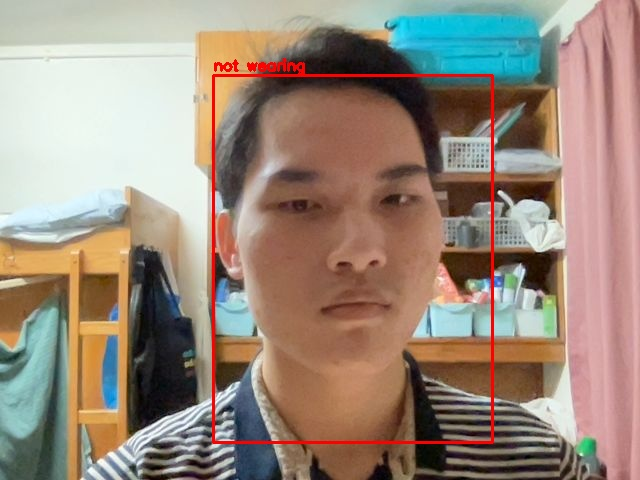

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

Shape of the image (480, 640, 3)
[[186.5434165  113.86698337 450.95754218 446.94282294   0.99999976]]
Saved to photo.jpg


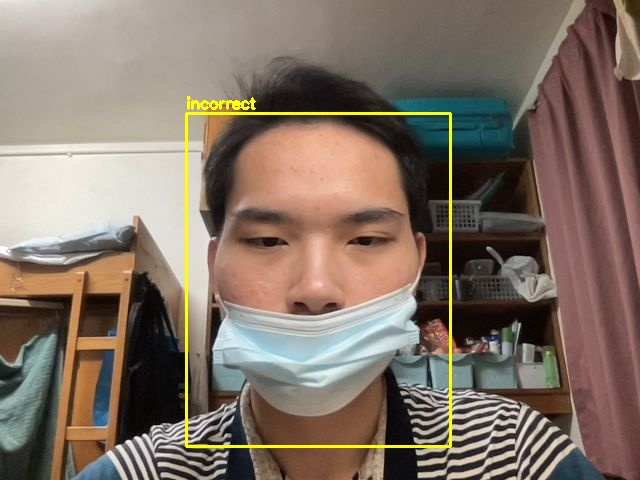

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

Shape of the image (480, 640, 3)
[[199.50576943  84.53971842 424.06210699 370.87062806   0.99816895]]
Saved to photo.jpg


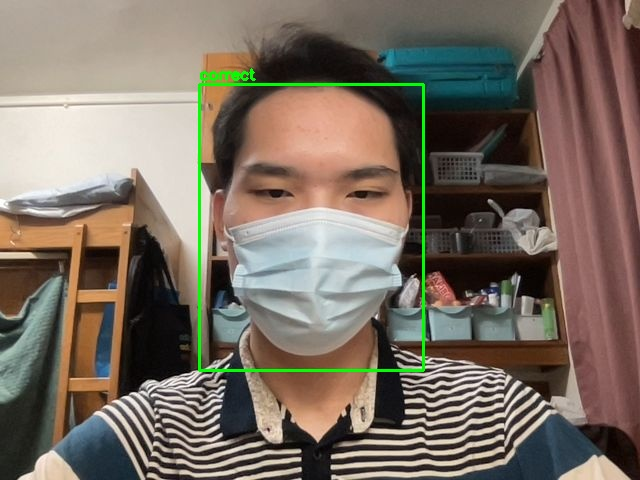

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Webcam Live-Video
Pipeline:
* start a video stream using our webcam as input 
* run each frame through the model and create an overlay image that contains bounding boxes and labels 
* overlay the bounding box image back onto the next frame of the video stream.

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

### Run
**Run the below cell to interact with the demo using your laptop/PC webcam**

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
        
    # detect faces
    faces, _ = mtcnn_detector.detect_face(img)

    #faces = faces.astype(int)

    # classify image
    for i in range(len(faces)):
        (x,y,x2,y2,pro) = faces[i]
        w=x2-x
        h=y2-y
        x=int(x)
        y=int(y)
        w=int(w)
        h=int(h)
        # crop face
        crop = img[y:y+h, x:x+w]
        #cv2_imshow(crop)
        crop = torch.Tensor(np.transpose(crop/255, (2, 0, 1))) 
        #print(crop.shape)

        # classify
        crop = transform(crop)
        crop = torch.unsqueeze(crop, axis=0).to(device)
        scores = effnet(crop)
        _, preds = scores.max(1)
        pred_label = str(preds.tolist()[0])

        class_color = {"0": (0, 255, 0), "1": (255, 255, 0), "2": (255, 0, 0)}

        # draw face bounding box on image
        bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),class_color[pred_label],2)

        # add text
        bbox_array = cv2.putText(bbox_array, id2label[pred_label],
                  (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, class_color[pred_label] ,2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>